Libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import folium

from yellow import plots
import yellow.trajectories as traj
from yellow import trips as yt

Input data

In [2]:
trips = pd.read_csv('~/saida.csv')
cities = pd.read_csv('~/cities.csv')
stats = pd.read_csv('~/traj-stats.csv')
intersects = pd.read_csv('~/streets-coverage.csv')
streets = pd.read_csv('~/street-intersections.csv')

streets = streets.groupby('tripid', as_index=False).agg({'ID': 'count'})
streets.columns = ['tripid', 'street_count']

trips = trips.merge(cities[cities.city == 'São Paulo'], on='tripid') \
             .merge(stats[(stats.total_distance >= 50) & (stats.total_duration >= 60)], on='tripid') \
             .merge(intersects, on='tripid') \
             .merge(streets, on='tripid')

trips['start_time'] = yt.extract_start_times(trips)
trips = trips[trips.start_time >= pd.Timestamp('2018-10-25 00:00:00')]

In [3]:
len(trips)

230197

### GPS take time variation

In [4]:
trips.take_time_std.describe()

count    230197.000000
mean         46.461163
std        1287.539455
min           0.000000
25%           0.841951
50%           1.828635
75%           4.423517
max      333070.895531
Name: take_time_std, dtype: float64

In [5]:
stat = trips.take_time_std
plt.figure(figsize=(10, 10))
plots.dist_chart(stat[stat < 100], 'GPS time variation', 'std. dev. (s)')
plt.show()

Taking value 40s as cut point

In [6]:
high_values = trips[trips.take_time_std >= 40]
len(high_values)

23135

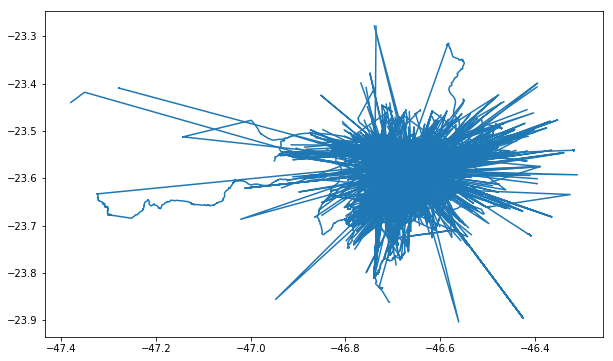

In [7]:
trajectories = traj.process_trajectories(high_values)
fig, ax = plt.subplots(figsize=(10, 10))
trajectories.plot(ax=ax)
plt.show()

In [8]:
good_values = trips[trips.take_time_std < 40]
len(good_values)

207062

Correlations

In [9]:
selected = good_values[good_values.total_duration < 1000*60]
plt.figure(figsize=(10, 10))
plt.title('Normal GPS time variation (< 40s)')
plt.xlabel('std. dev. (s)')
plt.ylabel('trip duration (min)')
plt.scatter(selected.take_time_std, selected.total_duration/60, alpha=0.3)
plt.show()

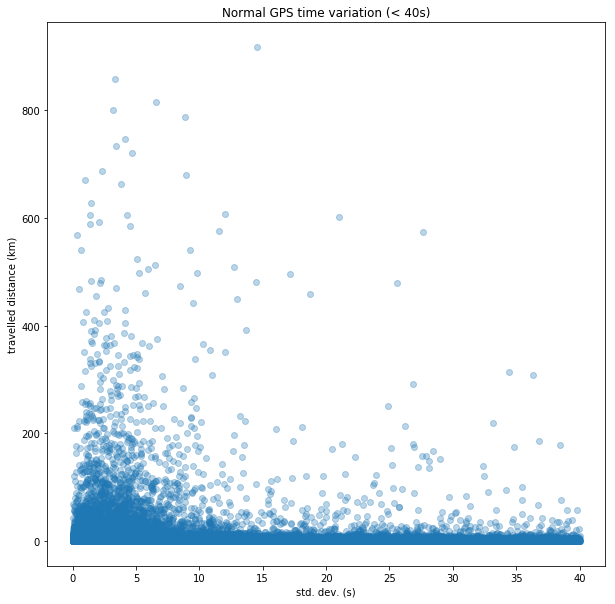

In [10]:
selected = good_values[good_values.total_distance < 1000*1000]
plt.figure(figsize=(10, 10))
plt.title('Normal GPS time variation (< 40s)')
plt.xlabel('std. dev. (s)')
plt.ylabel('travelled distance (km)')
plt.scatter(selected.take_time_std, selected.total_distance/1000, alpha=0.3)
plt.show()

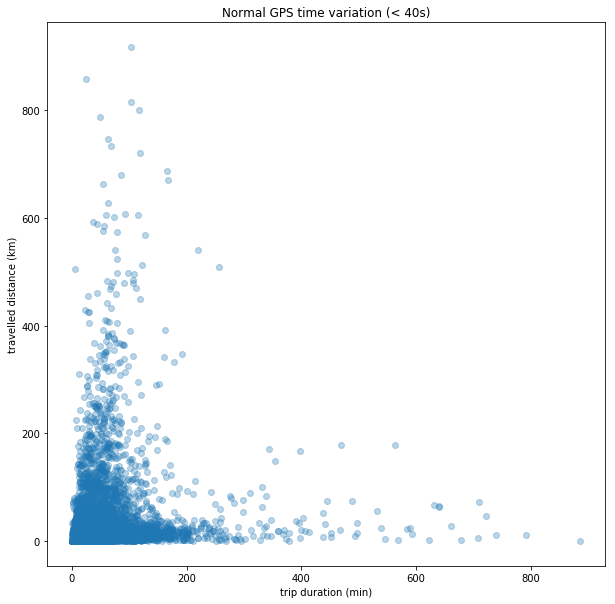

In [11]:
selected = good_values[(good_values.total_duration < 1000*60) & (good_values.total_distance < 1000*1000)]
plt.figure(figsize=(10, 10))
plt.title('Normal GPS time variation (< 40s)')
plt.xlabel('trip duration (min)')
plt.ylabel('travelled distance (km)')
plt.scatter(selected.total_duration/60, selected.total_distance/1000, alpha=0.3)
plt.show()

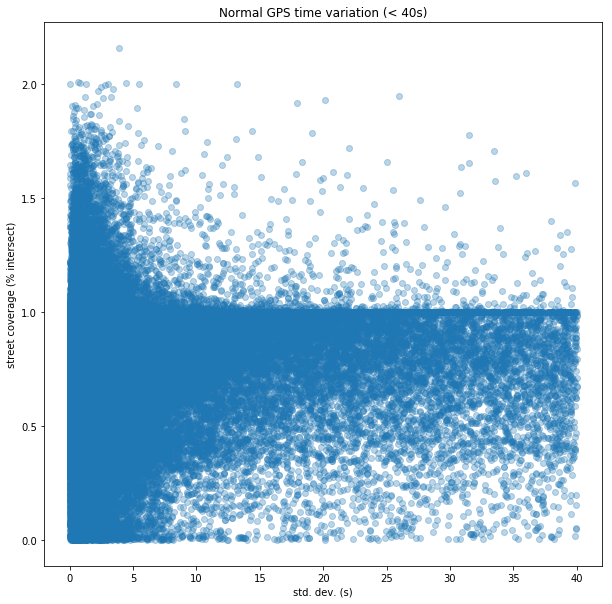

In [12]:
selected = good_values
plt.figure(figsize=(10, 10))
plt.title('Normal GPS time variation (< 40s)')
plt.xlabel('std. dev. (s)')
plt.ylabel('street coverage (% intersect)')
plt.scatter(selected.take_time_std, selected.intersect_perc, alpha=0.3)
plt.show()

In [22]:
selected = good_values[good_values.street_count < 5000]
plt.figure(figsize=(10, 10))
plt.title('Normal GPS time variation (< 40s)')
plt.xlabel('std. dev. (s)')
plt.ylabel('street intersection count')
plt.scatter(selected.take_time_std, selected.street_count, alpha=0.3)
plt.show()

Distributions

count    207062.000000
mean         14.277252
std          19.045872
min           1.000050
25%           5.241358
50%           8.881000
75%          15.866658
max        1729.220483
Name: total_duration, dtype: float64

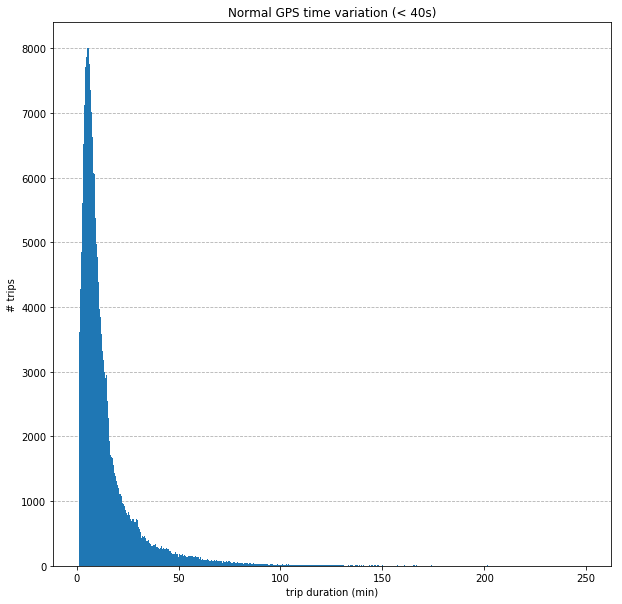

In [13]:
stat = good_values.total_duration / 60
display(stat.describe())
plt.figure(figsize=(10, 10))
plots.dist_chart(stat[stat < 250], 'Normal GPS time variation (< 40s)', 'trip duration (min)')
plt.show()

count    207062.000000
mean          3.060087
std          15.159339
min           0.050001
25%           0.790988
50%           1.393652
75%           2.580493
max        1986.279830
Name: total_distance, dtype: float64

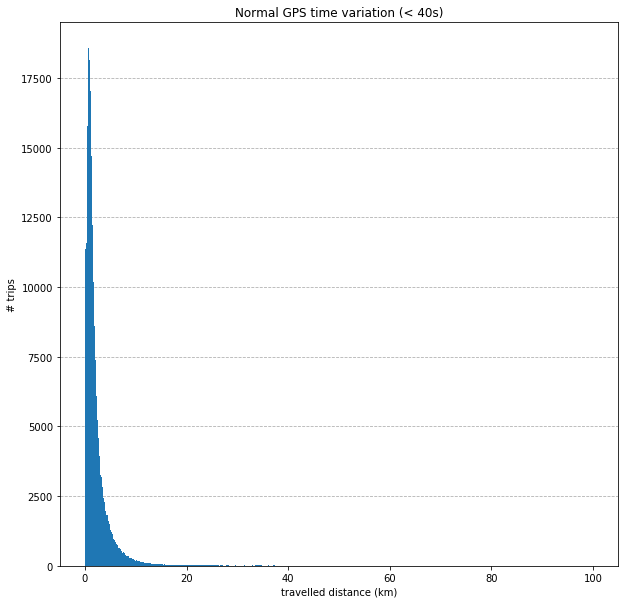

In [14]:
stat = good_values.total_distance / 1000
display(stat.describe())
plt.figure(figsize=(10, 10))
plots.dist_chart(stat[stat < 100], 'Normal GPS time variation (< 40s)', 'travelled distance (km)')
plt.show()

count    2.070620e+05
mean     8.441959e-01
std      2.109702e-01
min      6.884537e-08
25%      7.655306e-01
50%      9.093306e-01
75%      9.861944e-01
max      2.157626e+00
Name: intersect_perc, dtype: float64

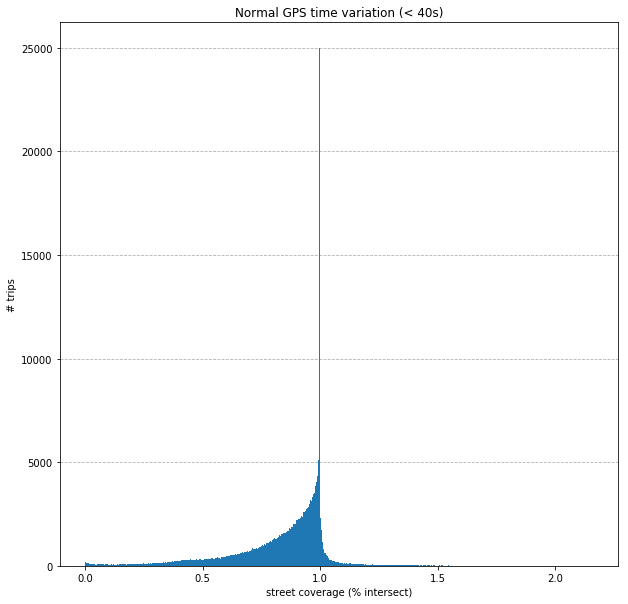

In [15]:
stat = good_values.intersect_perc
display(stat.describe())
plt.figure(figsize=(10, 10))
plots.dist_chart(stat, 'Normal GPS time variation (< 40s)', 'street coverage (% intersect)')
plt.show()

In [24]:
stat = good_values.street_count
display(stat.describe())
plt.figure(figsize=(10, 10))
plots.dist_chart(stat[stat < 1000], 'Normal GPS time variation (< 40s)', 'street intersections count')
plt.show()

count    207062.000000
mean         87.930929
std         220.667382
min           1.000000
25%          26.000000
50%          50.000000
75%          97.000000
max       23942.000000
Name: street_count, dtype: float64

Testing extreme values for next cuts

674


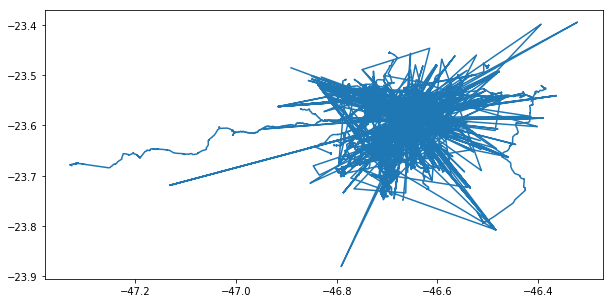

In [16]:
high_durations = good_values[good_values.total_duration > 120*60]
print(len(high_durations))
trajectories = traj.process_trajectories(high_durations)
fig, ax = plt.subplots(figsize=(10, 10))
trajectories.plot(ax=ax)
plt.show()

2478


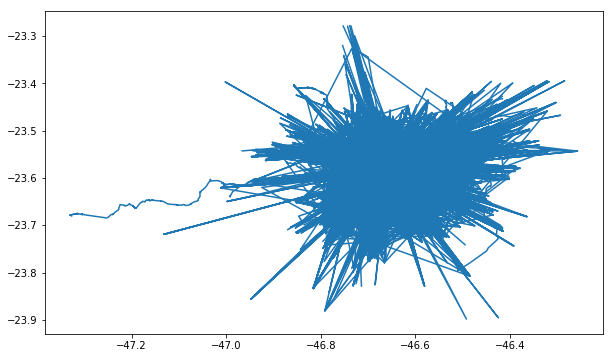

In [17]:
high_distances = good_values[good_values.total_distance > 20*1000]
print(len(high_distances))
trajectories = traj.process_trajectories(high_distances)
fig, ax = plt.subplots(figsize=(10, 10))
trajectories.plot(ax=ax)
plt.show()

5973


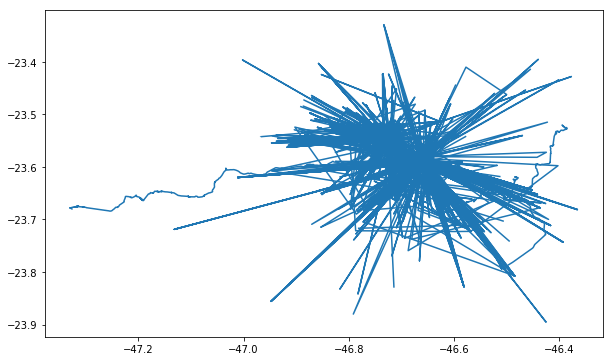

In [18]:
low_intersections = good_values[good_values.intersect_perc < 0.3]
print(len(low_intersections))
trajectories = traj.process_trajectories(low_intersections)
fig, ax = plt.subplots(figsize=(10, 10))
trajectories.plot(ax=ax)
plt.show()

17146


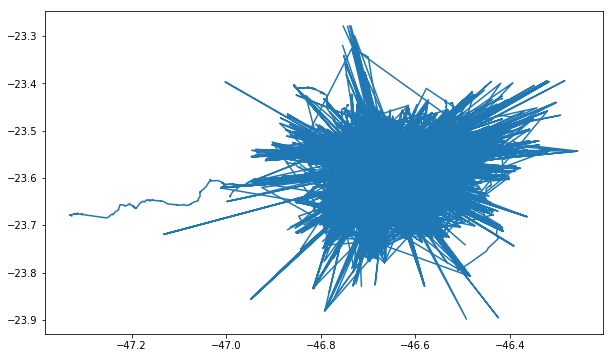

In [27]:
many_streets = good_values[good_values.street_count > 200]
print(len(many_streets))
trajectories = traj.process_trajectories(many_streets)
fig, ax = plt.subplots(figsize=(10, 10))
trajectories.plot(ax=ax)
plt.show()

Testing a new second cut
* extreme durations and distances

In [30]:
good_of_good = good_values[(good_values.total_duration <= 120*60) & (good_values.total_distance <= 20*1000)]
len(good_of_good)

204148

count    2.041480e+05
mean     8.494487e-01
std      2.064527e-01
min      6.884537e-08
25%      7.730390e-01
50%      9.118444e-01
75%      9.869440e-01
max      2.157626e+00
Name: intersect_perc, dtype: float64

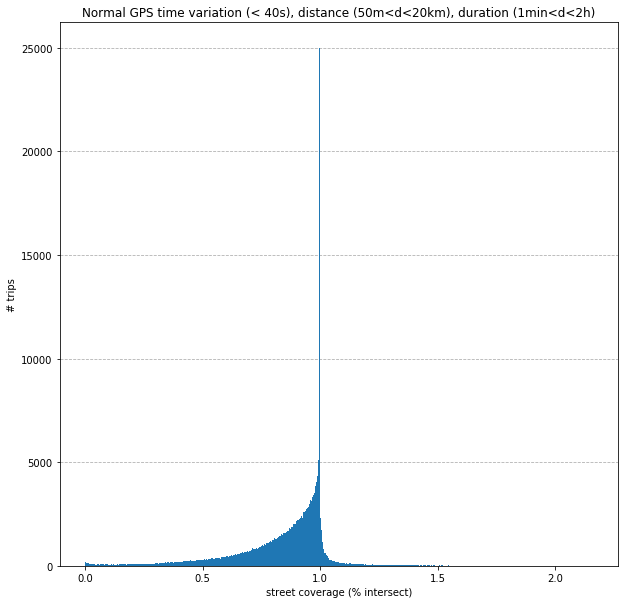

In [31]:
stat = good_of_good.intersect_perc
display(stat.describe())
plt.figure(figsize=(10, 10))
plots.dist_chart(stat, 'Normal GPS time variation (< 40s), distance (50m<d<20km), duration (1min<d<2h)', 
                 'street coverage (% intersect)')
plt.show()

count    204148.000000
mean         74.467161
std          77.826609
min           1.000000
25%          25.000000
50%          50.000000
75%          94.000000
max         960.000000
Name: street_count, dtype: float64

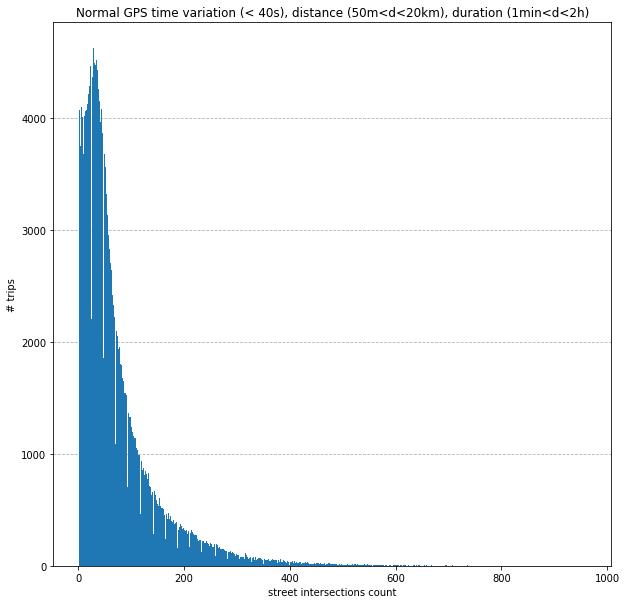

In [32]:
stat = good_of_good.street_count
display(stat.describe())
plt.figure(figsize=(10, 10))
plots.dist_chart(stat, 'Normal GPS time variation (< 40s), distance (50m<d<20km), duration (1min<d<2h)', 
                 'street intersections count')
plt.show()

In [35]:
low_intersections2 = good_of_good[good_of_good.intersect_perc < 0.5]
print(len(low_intersections2))
trajectories = traj.process_trajectories(low_intersections2)
fig, ax = plt.subplots(figsize=(10, 10))
trajectories.plot(ax=ax)
plt.show()

14601


4658


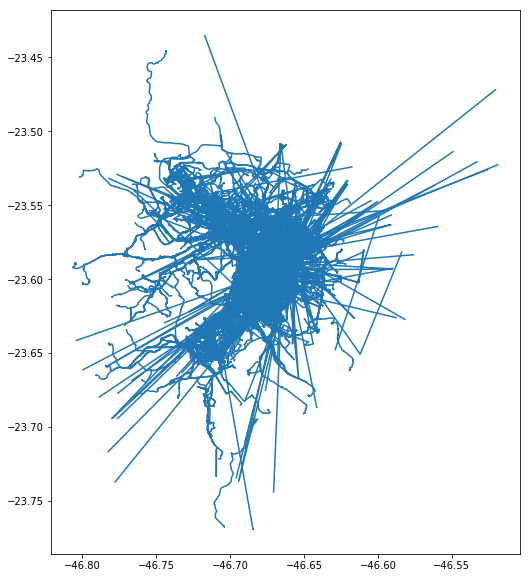

In [37]:
many_streets = good_of_good[good_of_good.street_count > 300]
print(len(many_streets))
trajectories = traj.process_trajectories(many_streets)
fig, ax = plt.subplots(figsize=(10, 10))
trajectories.plot(ax=ax)
plt.show()